# BERT

In [ ]:
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import pandas as pd
import numpy as np

In [ ]:
import tensorflow_hub as hub
import tensorflow_text as text
import tensorflow as tf

In [ ]:
!pip install tensorflow_text

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
df = pd.read_csv('/content/spam.csv', encoding='latin-1')
df.head()

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,ham,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN
1,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,NaN,NaN,NaN
3,ham,U dun say so early hor... U c already then say...,NaN,NaN,NaN
4,ham,"Nah I don't think he goes to usf, he lives aro...",NaN,NaN,NaN


In [ ]:
df.drop(columns=['Unnamed: 2', 'Unnamed: 3', 'Unnamed: 4'],inplace=True)
df.rename(columns = {'v1':'Category', 'v2':'Message'}, inplace = True)
df.head(5)

,Category,Message
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [ ]:
df.groupby('Category').describe()

Message                                                            \
           count unique                                                top   
Category                                                                     
ham         4825   4516                             Sorry, I'll call later   
spam         747    653  Please call our customer service representativ...   

               
         freq  
Category       
ham        30  
spam        4

In [ ]:
print('% Imbalanced Data:',747/4825)

% Imbalanced Data: 0.15481865284974095


In [ ]:
df_spam = df[df['Category']=='spam']
df_spam.shape

(747, 2)

In [ ]:
df_ham = df[df['Category']=='ham']
df_ham.shape

(4825, 2)

In [ ]:
df_ham_downsampled = df_ham.sample(df_spam.shape[0])
df_ham_downsampled.shape

(747, 2)

In [ ]:
df_balanced = pd.concat([df_ham_downsampled, df_spam])
df_balanced.shape

(1494, 2)

In [ ]:
df_balanced['spam']=df_balanced['Category'].apply(lambda x: 1 if x=='spam' else 0)
df_balanced.sample(5)

,Category,Message,spam
5196,spam,Spook up your mob with a Halloween collection ...,1
3494,spam,Wan2 win a Meet+Greet with Westlife 4 U or a m...,1
1459,spam,Bought one ringtone and now getting texts cost...,1
1852,spam,This is the 2nd time we have tried 2 contact u...,1
4468,ham,"Nothing, smsing u n xy lor. Sorry lor da guys ...",0


In [ ]:
df['spam']=df['Category'].apply(lambda x: 1 if x=='spam' else 0)
df.head()

,Category,Message,spam
0,ham,"Go until jurong point, crazy.. Available only ...",0
1,ham,Ok lar... Joking wif u oni...,0
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,1
3,ham,U dun say so early hor... U c already then say...,0
4,ham,"Nah I don't think he goes to usf, he lives aro...",0


In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(df_balanced['Message'],df_balanced['spam'], stratify=df_balanced['spam'])

In [ ]:
bert_preprocess = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3")
bert_encoder = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/4")

In [ ]:
def get_sentence_embeding(sentences):
    preprocessed_text = bert_preprocess(sentences)
    return bert_encoder(preprocessed_text)['pooled_output']

In [ ]:
c=get_sentence_embeding(['mango','banana','Narendra modi','data analytics','natural language processing'])

In [ ]:
#Functional Model

# Bert layers
#Text input passed to bert_preprocess
text_input = tf.keras.layers.Input(shape=(), dtype=tf.string, name='text')
preprocessed_text = bert_preprocess(text_input)
#Processed text passed to bert_encoder
outputs = bert_encoder(preprocessed_text)

# Neural network layers

#Dropout
l = tf.keras.layers.Dropout(0.1, name="dropout")(outputs['pooled_output'])
l = tf.keras.layers.Dense(1, activation='sigmoid', name="output")(l)

# Use inputs and outputs to construct a final model
model = tf.keras.Model(inputs=[text_input], outputs = [l])

In [ ]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 text (InputLayer)              [(None,)]            0           []                               
                                                                                                  
 keras_layer (KerasLayer)       {'input_type_ids':   0           ['text[0][0]']                   
                                (None, 128),                                                      
                                 'input_word_ids':                                                
                                (None, 128),                                                      
                                 'input_mask': (Non                                               
                                e, 128)}                                                      

In [ ]:
len(X_train)

1120

In [ ]:
METRICS = [tf.keras.metrics.BinaryAccuracy(name='accuracy'),tf.keras.metrics.Precision(name='precision'),
      tf.keras.metrics.Recall(name='recall')]

model.compile(optimizer='adam',loss='binary_crossentropy',metrics=METRICS)

In [ ]:
model.fit(X_train, y_train, epochs=10)

Epoch 1/10
35/35 [==============================] - 34s 331ms/step - loss: 0.6094 - accuracy: 0.6786 - precision: 0.6736 - recall: 0.6929
Epoch 2/10
35/35 [==============================] - 12s 336ms/step - loss: 0.4934 - accuracy: 0.8214 - precision: 0.8136 - recall: 0.8339
Epoch 3/10
35/35 [==============================] - 13s 362ms/step - loss: 0.4384 - accuracy: 0.8455 - precision: 0.8389 - recall: 0.8554
Epoch 4/10
35/35 [==============================] - 13s 357ms/step - loss: 0.3962 - accuracy: 0.8536 - precision: 0.8462 - recall: 0.8643
Epoch 5/10
35/35 [==============================] - 12s 347ms/step - loss: 0.3724 - accuracy: 0.8661 - precision: 0.8622 - recall: 0.8714
Epoch 6/10
35/35 [==============================] - 12s 330ms/step - loss: 0.3445 - accuracy: 0.8741 - precision: 0.8656 - recall: 0.8857
Epoch 7/10
35/35 [==============================] - 12s 342ms/step - loss: 0.3222 - accuracy: 0.9009 - precision: 0.8891 - recall: 0.9161
Epoch 8/10
35/35 [================

In [ ]:
model.evaluate(X_test, y_test)

12/12 [==============================] - 5s 340ms/step - loss: 0.2602 - accuracy: 0.9251 - precision: 0.9119 - recall: 0.9412


[0.26016488671302795,
 0.9251337051391602,
 0.9119170904159546,
 0.9411764740943909]

In [ ]:
y_predicted = model.predict(X_test)
y_predicted = y_predicted.flatten()

12/12 [==============================] - 5s 374ms/step


In [ ]:
y_predicted = np.where(y_predicted > 0.5, 1, 0)
y_predicted

array([1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0,
       1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1,
       1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1,
       0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1,
       0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1,
       1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1,
       0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0,
       1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0,
       0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0,
       1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1,
       1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0,
       1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1,
       1, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1,

In [ ]:
from sklearn.metrics import confusion_matrix, classification_report
cm = confusion_matrix(y_test, y_predicted)
cm

array([[170,  17],
       [ 11, 176]])

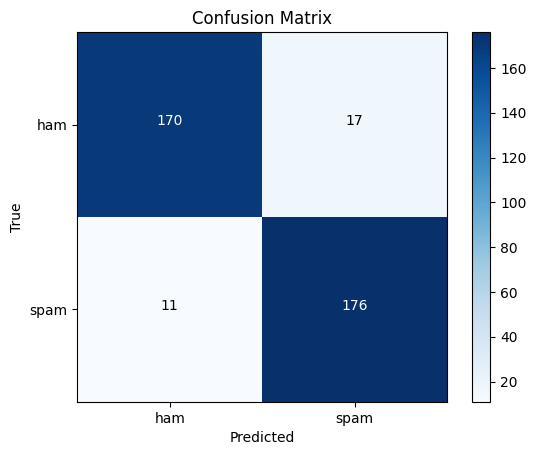

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()
tick_marks = np.arange(2)
plt.xticks(tick_marks, ['ham', 'spam'])
plt.yticks(tick_marks, ['ham', 'spam'])
plt.xlabel('Predicted')
plt.ylabel('True')

thresh = cm.max() / 2
for i, j in np.ndindex(cm.shape):
    plt.text(j, i, format(cm[i, j], 'd'), horizontalalignment="center", color="white" if cm[i, j] > thresh else "black")

In [ ]:
from sklearn.metrics import classification_report

print(classification_report(y_test, y_predicted))

              precision    recall  f1-score   support

           0       0.94      0.91      0.92       187
           1       0.91      0.94      0.93       187

    accuracy                           0.93       374
   macro avg       0.93      0.93      0.93       374
weighted avg       0.93      0.93      0.93       374



# TF-IDF, N-Grams, BoW

TF-IDF

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline

In [ ]:
# Define the maximum number of features
max_features = 1000

# Create a TfidfVectorizer object with the specified maximum number of features
vectorizer = TfidfVectorizer(max_features=max_features)

# Create a MultinomialNB object for classification
clf = MultinomialNB()

# Create a Pipeline object to combine the vectorizer and classifier
pipeline = Pipeline([
    ('vectorizer', vectorizer),
    ('clf', clf)
])

In [ ]:
import pandas as pd

df = pd.read_csv('/content/spam.csv', encoding='latin-1')
df.head()

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,ham,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN
1,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,NaN,NaN,NaN
3,ham,U dun say so early hor... U c already then say...,NaN,NaN,NaN
4,ham,"Nah I don't think he goes to usf, he lives aro...",NaN,NaN,NaN


In [ ]:
df.drop(columns=['Unnamed: 2', 'Unnamed: 3', 'Unnamed: 4'],inplace=True)
df.rename(columns = {'v1':'Category', 'v2':'Message'}, inplace = True)
df.head(5)

,Category,Message
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [ ]:
df['Message'] = df['Message'].astype(str)

In [ ]:
import re
import string

def preprocess(text):
    text = re.sub(r'[^\w\s\']', ' ', text)
    text = re.sub(r' +', ' ', text)
    return text.strip().lower()

def remove_punctuation(text):
    punctuationfree="".join([i for i in text if i not in string.punctuation])
    return punctuationfree
#storing the puntuation free text
df['Message']= df['Message'].apply(lambda x:remove_punctuation(x))
df['Message']= df['Message'].apply(lambda x:preprocess(x))
df.head()

,Category,Message
0,ham,go until jurong point crazy available only in ...
1,ham,ok lar joking wif u oni
2,spam,free entry in 2 a wkly comp to win fa cup fina...
3,ham,u dun say so early hor u c already then say
4,ham,nah i dont think he goes to usf he lives aroun...


In [ ]:
df_spam = df[df['Category']=='spam']
df_ham = df[df['Category']=='ham']
df_ham_downsampled = df_ham.sample(df_spam.shape[0])
df = pd.concat([df_ham_downsampled, df_spam])
df.head()

,Category,Message
3847,ham,can you plz tell me the ans bslvyl sent via fu...
866,ham,same here but i consider walls and bunkers and...
5571,ham,rofl its true to its name
3701,ham,hey loverboy i love you i had to tell i look a...
5459,ham,if you hear a loud scream in about ltgt minute...


In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(df['Message'], df['Category'], test_size=0.3)

In [ ]:
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((1045,), (1045,), (449,), (449,))

In [ ]:
pipeline.fit(X_train, y_train)

Pipeline(steps=[('vectorizer', TfidfVectorizer(max_features=1000)),
                ('clf', MultinomialNB())])

In [ ]:
predicts = pipeline.predict(X_test)
print(predicts)

['ham' 'ham' 'ham' 'ham' 'ham' 'spam' 'ham' 'ham' 'spam' 'spam' 'ham'
 'spam' 'ham' 'spam' 'spam' 'ham' 'ham' 'ham' 'spam' 'spam' 'spam' 'spam'
 'spam' 'ham' 'spam' 'ham' 'ham' 'ham' 'spam' 'ham' 'spam' 'ham' 'spam'
 'ham' 'spam' 'ham' 'spam' 'spam' 'ham' 'ham' 'ham' 'spam' 'ham' 'spam'
 'spam' 'ham' 'spam' 'ham' 'spam' 'spam' 'ham' 'ham' 'ham' 'ham' 'spam'
 'spam' 'ham' 'ham' 'spam' 'ham' 'ham' 'ham' 'ham' 'ham' 'spam' 'ham'
 'ham' 'spam' 'ham' 'spam' 'spam' 'spam' 'ham' 'ham' 'ham' 'spam' 'spam'
 'spam' 'ham' 'ham' 'ham' 'spam' 'ham' 'spam' 'spam' 'ham' 'ham' 'spam'
 'spam' 'ham' 'ham' 'ham' 'spam' 'spam' 'spam' 'spam' 'spam' 'ham' 'spam'
 'spam' 'spam' 'ham' 'ham' 'ham' 'spam' 'ham' 'ham' 'spam' 'ham' 'spam'
 'spam' 'spam' 'ham' 'ham' 'ham' 'ham' 'spam' 'ham' 'spam' 'ham' 'spam'
 'ham' 'spam' 'spam' 'spam' 'spam' 'spam' 'ham' 'spam' 'spam' 'spam' 'ham'
 'spam' 'ham' 'spam' 'ham' 'spam' 'spam' 'spam' 'spam' 'spam' 'ham' 'spam'
 'spam' 'ham' 'spam' 'spam' 'spam' 'spam' 'ham' 'ham' 'sp

In [ ]:
from sklearn.metrics import classification_report

print(classification_report(y_test, predicts))

              precision    recall  f1-score   support

         ham       0.97      0.96      0.96       243
        spam       0.95      0.97      0.96       206

    accuracy                           0.96       449
   macro avg       0.96      0.96      0.96       449
weighted avg       0.96      0.96      0.96       449



In [ ]:
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_test, predicts)
cm

array([[233,  10],
       [  7, 199]])

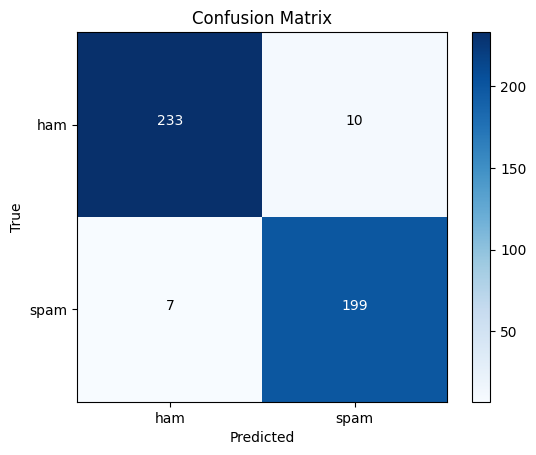

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()
tick_marks = np.arange(2)
plt.xticks(tick_marks, ['ham', 'spam'])
plt.yticks(tick_marks, ['ham', 'spam'])
plt.xlabel('Predicted')
plt.ylabel('True')

thresh = cm.max() / 2
for i, j in np.ndindex(cm.shape):
    plt.text(j, i, format(cm[i, j], 'd'), horizontalalignment="center", color="white" if cm[i, j] > thresh else "black")

BoW

In [ ]:
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score

In [ ]:
df = pd.read_csv('/content/spam.csv', encoding='latin-1')
df.head()

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,ham,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN
1,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,NaN,NaN,NaN
3,ham,U dun say so early hor... U c already then say...,NaN,NaN,NaN
4,ham,"Nah I don't think he goes to usf, he lives aro...",NaN,NaN,NaN


In [ ]:
df.drop(columns=['Unnamed: 2', 'Unnamed: 3', 'Unnamed: 4'],inplace=True)
df.rename(columns = {'v1':'Category', 'v2':'Message'}, inplace = True)
df.head(5)

,Category,Message
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [ ]:
df['Message'] = df['Message'].astype(str)

In [ ]:
import re
import string

def preprocess(text):
    text = re.sub(r'[^\w\s\']', ' ', text)
    text = re.sub(r' +', ' ', text)
    return text.strip().lower()

def remove_punctuation(text):
    punctuationfree="".join([i for i in text if i not in string.punctuation])
    return punctuationfree
#storing the puntuation free text
df['Message']= df['Message'].apply(lambda x:remove_punctuation(x))
df['Message']= df['Message'].apply(lambda x:preprocess(x))
df.head()

,Category,Message
0,ham,go until jurong point crazy available only in ...
1,ham,ok lar joking wif u oni
2,spam,free entry in 2 a wkly comp to win fa cup fina...
3,ham,u dun say so early hor u c already then say
4,ham,nah i dont think he goes to usf he lives aroun...


In [ ]:
df_spam = df[df['Category']=='spam']
df_ham = df[df['Category']=='ham']
df_ham_downsampled = df_ham.sample(df_spam.shape[0])
df = pd.concat([df_ham_downsampled, df_spam])
df.head()

,Category,Message
2995,ham,they released vday shirts and when u put it on...
3690,ham,sir i am waiting for your call once free pleas...
753,ham,when did you get to the library
3087,ham,wnevr i wana fal in luv vth my books my bed fa...
668,ham,have a good evening ttyl


In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(df['Message'],df['Category'], test_size=0.3)
vectorizer = CountVectorizer()

In [ ]:
X_train = vectorizer.fit_transform(X_train)
X_test = vectorizer.transform(X_test)

In [ ]:
clf = MultinomialNB()
clf.fit(X_train, y_train)

MultinomialNB()

In [ ]:
y_pred = clf.predict(X_test)

In [ ]:
acc = accuracy_score(y_train, clf.predict(X_train))
print('Training accuracy:', acc)

Training accuracy: 0.9837320574162679


In [ ]:
from sklearn.metrics import classification_report

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

         ham       0.96      0.99      0.97       223
        spam       0.99      0.96      0.97       226

    accuracy                           0.97       449
   macro avg       0.97      0.97      0.97       449
weighted avg       0.97      0.97      0.97       449



In [ ]:
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_test, y_pred)
cm

array([[220,   3],
       [  9, 217]])

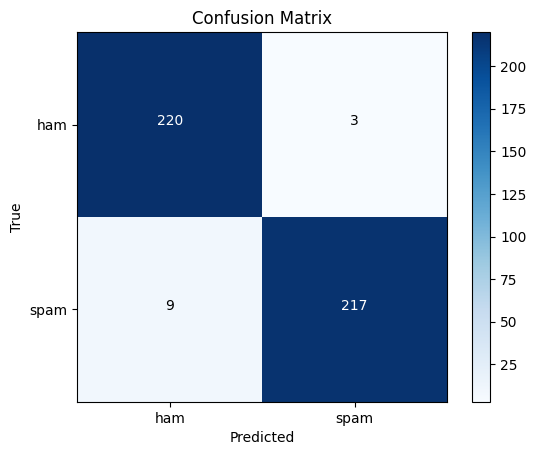

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()
tick_marks = np.arange(2)
plt.xticks(tick_marks, ['ham', 'spam'])
plt.yticks(tick_marks, ['ham', 'spam'])
plt.xlabel('Predicted')
plt.ylabel('True')

thresh = cm.max() / 2
for i, j in np.ndindex(cm.shape):
    plt.text(j, i, format(cm[i, j], 'd'), horizontalalignment="center", color="white" if cm[i, j] > thresh else "black")

N-Grams

In [ ]:
import pandas as pd

df = pd.read_csv('spam.csv', encoding='latin-1')
df.head()

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,ham,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN
1,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,NaN,NaN,NaN
3,ham,U dun say so early hor... U c already then say...,NaN,NaN,NaN
4,ham,"Nah I don't think he goes to usf, he lives aro...",NaN,NaN,NaN


In [ ]:
df.drop(columns=['Unnamed: 2', 'Unnamed: 3', 'Unnamed: 4'],inplace=True)
df.rename(columns = {'v1':'Category', 'v2':'Message'}, inplace = True)
df.head(5)

,Category,Message
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [ ]:
df['Message'] = df['Message'].astype(str)

In [ ]:
import re
import string

def preprocess(text):
    text = re.sub(r'[^\w\s\']', ' ', text)
    text = re.sub(r' +', ' ', text)
    return text.strip().lower()

def remove_punctuation(text):
    punctuationfree="".join([i for i in text if i not in string.punctuation])
    return punctuationfree
#storing the puntuation free text
df['Message']= df['Message'].apply(lambda x:remove_punctuation(x))
df['Message']= df['Message'].apply(lambda x:preprocess(x))
df.head()

,Category,Message
0,ham,go until jurong point crazy available only in ...
1,ham,ok lar joking wif u oni
2,spam,free entry in 2 a wkly comp to win fa cup fina...
3,ham,u dun say so early hor u c already then say
4,ham,nah i dont think he goes to usf he lives aroun...


In [ ]:
df_spam = df[df['Category']=='spam']
df_ham = df[df['Category']=='ham']
df_ham_downsampled = df_ham.sample(df_spam.shape[0])
df = pd.concat([df_ham_downsampled, df_spam])
df['spam']=df['Category'].apply(lambda x: 1 if x=='spam' else 0)
df.head()

,Category,Message,spam
5489,ham,oh thanks a loti already bought 2 eggs,0
804,ham,k ill be there before 4,0
3619,ham,i meant as an apology from me for texting you ...,0
1581,ham,hhahhaahahah rofl wtf nig was leonardo in your...,0
2365,ham,ok try to do week end course in coimbatore,0


In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(df['Message'], df['Category'], test_size=0.3)

In [ ]:
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((1045,), (1045,), (449,), (449,))

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline

ngram_range = (1, 2)
max_features = 1000

# Create a CountVectorizer object with the specified n-gram range and maximum number of features
vectorizer = CountVectorizer(ngram_range=ngram_range, max_features=max_features)

# Create a MultinomialNB object for classification
clf = MultinomialNB()

# Create a Pipeline object to combine the vectorizer and classifier
pipeline = Pipeline([
    ('vectorizer', vectorizer),
    ('clf', clf)
])

In [ ]:
pipeline.fit(X_train, y_train)

Pipeline(steps=[('vectorizer',
                 CountVectorizer(max_features=1000, ngram_range=(1, 2))),
                ('clf', MultinomialNB())])

In [ ]:
prediction = pipeline.predict(X_test)

In [ ]:
import numpy as np
from sklearn.metrics import f1_score
predicts = pipeline.predict(X_test)
print(predicts)
score = np.round(f1_score(y_test, prediction, average='micro'),4)
print('F-1 score of model with n-gram range of {}: {}'.format(ngram_range, score))

['spam' 'ham' 'spam' 'ham' 'ham' 'spam' 'ham' 'spam' 'spam' 'spam' 'ham'
 'ham' 'ham' 'ham' 'ham' 'ham' 'spam' 'ham' 'spam' 'spam' 'ham' 'ham'
 'ham' 'ham' 'spam' 'spam' 'spam' 'ham' 'spam' 'spam' 'spam' 'ham' 'ham'
 'ham' 'spam' 'ham' 'spam' 'ham' 'ham' 'spam' 'spam' 'ham' 'spam' 'spam'
 'ham' 'ham' 'ham' 'ham' 'spam' 'ham' 'spam' 'ham' 'ham' 'spam' 'ham'
 'ham' 'ham' 'spam' 'ham' 'ham' 'spam' 'ham' 'ham' 'spam' 'ham' 'ham'
 'spam' 'ham' 'ham' 'ham' 'spam' 'ham' 'spam' 'ham' 'ham' 'spam' 'ham'
 'spam' 'spam' 'ham' 'spam' 'ham' 'ham' 'ham' 'spam' 'ham' 'spam' 'ham'
 'spam' 'spam' 'ham' 'ham' 'ham' 'ham' 'spam' 'ham' 'ham' 'ham' 'spam'
 'ham' 'ham' 'ham' 'spam' 'spam' 'spam' 'spam' 'spam' 'ham' 'ham' 'ham'
 'ham' 'ham' 'ham' 'ham' 'ham' 'ham' 'ham' 'ham' 'spam' 'spam' 'ham'
 'spam' 'ham' 'spam' 'spam' 'ham' 'ham' 'ham' 'spam' 'spam' 'ham' 'spam'
 'spam' 'spam' 'ham' 'ham' 'spam' 'ham' 'ham' 'spam' 'spam' 'ham' 'ham'
 'ham' 'ham' 'spam' 'ham' 'spam' 'ham' 'ham' 'ham' 'spam' 'spam' 'ham'


In [ ]:
from sklearn.metrics import classification_report

print(classification_report(y_test,prediction))

              precision    recall  f1-score   support

         ham       0.91      1.00      0.95       220
        spam       1.00      0.90      0.95       229

    accuracy                           0.95       449
   macro avg       0.95      0.95      0.95       449
weighted avg       0.95      0.95      0.95       449



In [ ]:
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_test, prediction)
cm

array([[219,   1],
       [ 22, 207]])

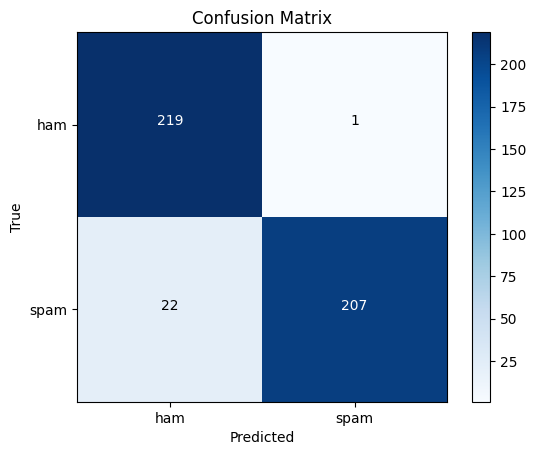

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()
tick_marks = np.arange(2)
plt.xticks(tick_marks, ['ham', 'spam'])
plt.yticks(tick_marks, ['ham', 'spam'])
plt.xlabel('Predicted')
plt.ylabel('True')

thresh = cm.max() / 2
for i, j in np.ndindex(cm.shape):
    plt.text(j, i, format(cm[i, j], 'd'), horizontalalignment="center", color="white" if cm[i, j] > thresh else "black")

# FastText, Word2Vec, GloVe

FastText

In [ ]:
import pandas as pd

df = pd.read_csv('spam.csv', encoding='latin-1')
df.head()

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,ham,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN
1,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,NaN,NaN,NaN
3,ham,U dun say so early hor... U c already then say...,NaN,NaN,NaN
4,ham,"Nah I don't think he goes to usf, he lives aro...",NaN,NaN,NaN


In [ ]:
df.drop(columns=['Unnamed: 2', 'Unnamed: 3', 'Unnamed: 4'],inplace=True)
df.rename(columns = {'v1':'Category', 'v2':'Message'}, inplace = True)
df.head(5)

,Category,Message
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [ ]:
df['Message'] = df['Message'].astype(str)

In [ ]:
import re
import string

def preprocess(text):
    text = re.sub(r'[^\w\s\']', ' ', text)
    text = re.sub(r' +', ' ', text)
    return text.strip().lower()

def remove_punctuation(text):
    punctuationfree="".join([i for i in text if i not in string.punctuation])
    return punctuationfree
#storing the puntuation free text
df['Message']= df['Message'].apply(lambda x:remove_punctuation(x))
df['Message']= df['Message'].apply(lambda x:preprocess(x))
df.head()

,Category,Message
0,ham,go until jurong point crazy available only in ...
1,ham,ok lar joking wif u oni
2,spam,free entry in 2 a wkly comp to win fa cup fina...
3,ham,u dun say so early hor u c already then say
4,ham,nah i dont think he goes to usf he lives aroun...


In [ ]:
df['Category'] = '__label__' + df['Category'].astype(str)
df.head()

,Category,Message
0,__label__ham,go until jurong point crazy available only in ...
1,__label__ham,ok lar joking wif u oni
2,__label__spam,free entry in 2 a wkly comp to win fa cup fina...
3,__label__ham,u dun say so early hor u c already then say
4,__label__ham,nah i dont think he goes to usf he lives aroun...


In [ ]:
df_spam = df[df['Category']=='__label__spam']
df_ham = df[df['Category']=='__label__ham']
df_ham_downsampled = df_ham.sample(df_spam.shape[0])
df = pd.concat([df_ham_downsampled, df_spam])
df.head()

,Category,Message
1626,__label__ham,dear how you are you ok
5197,__label__ham,i like cheap but i û m happy to splash out on ...
3573,__label__ham,yeah sure ill leave in a min
900,__label__ham,probably money worries things are coming due a...
3301,__label__ham,stop calling everyone saying i might have canc...


In [ ]:
df['category_message'] = df['Category'] + ' ' + df['Message']
df.head()

,Category,Message,category_message
1626,__label__ham,dear how you are you ok,__label__ham dear how you are you ok
5197,__label__ham,i like cheap but i û m happy to splash out on ...,__label__ham i like cheap but i û m happy to s...
3573,__label__ham,yeah sure ill leave in a min,__label__ham yeah sure ill leave in a min
900,__label__ham,probably money worries things are coming due a...,__label__ham probably money worries things are...
3301,__label__ham,stop calling everyone saying i might have canc...,__label__ham stop calling everyone saying i mi...


In [ ]:
from sklearn.model_selection import train_test_split

train, test = train_test_split(df, test_size=0.2)

In [ ]:
train.to_csv('spam.train', columns=['category_message'], index=False,  header=False)
test.to_csv('spam.test', columns=['category_message'], index=False,  header=False)

In [ ]:
!pip install fasttext

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 68.8/68.8 kB 3.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Using cached pybind11-2.10.4-py3-none-any.whl (222 kB)
  Created wheel for fasttext: filename=fasttext-0.9.2-cp310-cp310-linux_x86_64.whl size=4393309 sha256=fc1639b8227cad6ec7f4ec9d5b218ae63ce208edc6ed923d3dce87b4a71119c0
  Stored in directory: /root/.cache/pip/wheels/a5/13/75/f811c84a8ab36eedbaef977a6a58a98990e8e0f1967f98f394
Successfully built fasttext


In [ ]:
import fasttext

model = fasttext.train_supervised(input='spam.train')
model.test('spam.test')

(299, 0.9565217391304348, 0.9565217391304348)

In [ ]:
test['Message']

1903    free entry in 2 a weekly comp for a chance to ...
5353    guai ìï shd haf seen him when hes naughty ìï s...
2804                      i think its all still in my car
3044    hello yeah ive just got out of the bath and ne...
5178    sms auction a brand new nokia 7250 is up 4 auc...
                              ...                        
5074    this is the 2nd attempt to contract u you have...
400     free ringtone text first to 87131 for a poly o...
2548    honestly ive just made a lovely cup of tea and...
1268    can u get 2 phone now i wanna chat 2 set up me...
2260    splashmobile choose from 1000s of gr8 tones ea...
Name: Message, Length: 299, dtype: object

In [ ]:
ground_truth_labels = []
test_texts = []

In [ ]:
ground_truth_label = test['Category'].tolist()
test_texts = test['category_message'].tolist()

In [ ]:
predictions = []
for text in test_texts:
    text = text.replace('\n', '')  # Remove newline character
    prediction = model.predict(text)[0][0].replace('__label__', '')
    predictions.append(prediction)

In [ ]:
ground_truth_labels = []
for text in ground_truth_label:
    text = text.lower()
    text = text.replace('\n', '')  # Remove newline character
    ground_truth_labels.append(text.replace('__label__', ''))

In [ ]:
from sklearn.metrics import classification_report

print(classification_report(ground_truth_labels, predictions))

              precision    recall  f1-score   support

         ham       0.94      0.97      0.96       156
        spam       0.97      0.94      0.95       143

    accuracy                           0.96       299
   macro avg       0.96      0.96      0.96       299
weighted avg       0.96      0.96      0.96       299



In [ ]:
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(ground_truth_labels, predictions)
cm

array([[152,   4],
       [  9, 134]])

In [ ]:
from sklearn.metrics import accuracy_score

accuracy = accuracy_score(ground_truth_labels, predictions)
print(accuracy)

0.9565217391304348


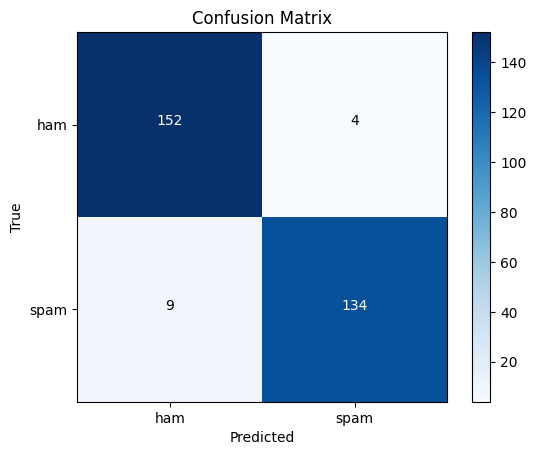

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()
tick_marks = np.arange(2)
plt.xticks(tick_marks, ['ham', 'spam'])
plt.yticks(tick_marks, ['ham', 'spam'])
plt.xlabel('Predicted')
plt.ylabel('True')

thresh = cm.max() / 2
for i, j in np.ndindex(cm.shape):
    plt.text(j, i, format(cm[i, j], 'd'), horizontalalignment="center", color="white" if cm[i, j] > thresh else "black")

Word2Vec

In [ ]:
from gensim.models import Word2Vec
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report

In [ ]:
# Define the dimension of the word embeddings
embedding_dim = 100

In [ ]:
import pandas as pd

df = pd.read_csv('spam.csv', encoding='latin-1')
df.head()

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,ham,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN
1,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,NaN,NaN,NaN
3,ham,U dun say so early hor... U c already then say...,NaN,NaN,NaN
4,ham,"Nah I don't think he goes to usf, he lives aro...",NaN,NaN,NaN


In [ ]:
df.drop(columns=['Unnamed: 2', 'Unnamed: 3', 'Unnamed: 4'],inplace=True)
df.rename(columns = {'v1':'Category', 'v2':'Message'}, inplace = True)
df.head(5)

,Category,Message
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [ ]:
df['Message'] = df['Message'].astype(str)

In [ ]:
import re
import string

def preprocess(text):
    text = re.sub(r'[^\w\s\']', ' ', text)
    text = re.sub(r' +', ' ', text)
    return text.strip().lower()

def remove_punctuation(text):
    punctuationfree="".join([i for i in text if i not in string.punctuation])
    return punctuationfree
#storing the puntuation free text
df['Message']= df['Message'].apply(lambda x:remove_punctuation(x))
df['Message']= df['Message'].apply(lambda x:preprocess(x))
df.head()

,Category,Message
0,ham,go until jurong point crazy available only in ...
1,ham,ok lar joking wif u oni
2,spam,free entry in 2 a wkly comp to win fa cup fina...
3,ham,u dun say so early hor u c already then say
4,ham,nah i dont think he goes to usf he lives aroun...


In [ ]:
df_spam = df[df['Category']=='spam']
df_ham = df[df['Category']=='ham']
df_ham_downsampled = df_ham.sample(df_spam.shape[0])
df = pd.concat([df_ham_downsampled, df_spam])
df.head()

,Category,Message
2411,ham,come to me right now ahmad
3006,ham,ah you see you have to be in the lingo i will ...
323,ham,that would be great well be at the guild could...
1229,ham,jus ans me lar ull noe later
866,ham,same here but i consider walls and bunkers and...


In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(df['Message'], df['Category'], test_size=0.3)

In [ ]:
# Tokenize the training data
tokenized_training_data = [sentence.split() for sentence in X_train]


In [ ]:
# Train the Word2Vec model on the tokenized training data
model = Word2Vec(sentences=tokenized_training_data, vector_size=embedding_dim, window=5, min_count=1, workers=4)

In [ ]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((1045,), (449,), (1045,), (449,))

In [ ]:
# Tokenize the test data
tokenized_test_data = [sentence.split() for sentence in X_test]

# Get the embeddings for the training and test data
training_data_embeddings = []
for sentence in tokenized_training_data:
    embeddings = [model.wv[word] for word in sentence if word in model.wv]
    if embeddings:
        training_data_embeddings.append(sum(embeddings) / len(embeddings))
    else:
        training_data_embeddings.append([0] * embedding_dim)

test_data_embeddings = []
for sentence in tokenized_test_data:
    embeddings = [model.wv[word] for word in sentence if word in model.wv]
    if embeddings:
        test_data_embeddings.append(sum(embeddings) / len(embeddings))
    else:
        test_data_embeddings.append([0] * embedding_dim)


In [ ]:
# Train a logistic regression classifier on top of the embeddings
classifier = LogisticRegression()
classifier.fit(training_data_embeddings, y_train)

# Use the classifier to predict the labels for the test data
predicted_labels = classifier.predict(test_data_embeddings)


In [ ]:
print(classification_report(y_test, predicted_labels))

              precision    recall  f1-score   support

         ham       0.55      0.38      0.45       216
        spam       0.55      0.71      0.62       233

    accuracy                           0.55       449
   macro avg       0.55      0.54      0.53       449
weighted avg       0.55      0.55      0.54       449



In [ ]:
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_test, predicted_labels)
cm

array([[ 82, 134],
       [ 68, 165]])

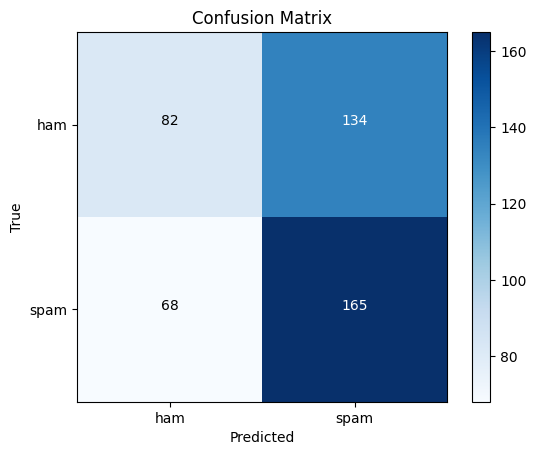

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()
tick_marks = np.arange(2)
plt.xticks(tick_marks, ['ham', 'spam'])
plt.yticks(tick_marks, ['ham', 'spam'])
plt.xlabel('Predicted')
plt.ylabel('True')

thresh = cm.max() / 2
for i, j in np.ndindex(cm.shape):
    plt.text(j, i, format(cm[i, j], 'd'), horizontalalignment="center", color="white" if cm[i, j] > thresh else "black")

GloVe

In [ ]:
import pandas as pd

df = pd.read_csv('spam.csv', encoding='latin-1')
df.head()

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,ham,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN
1,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,NaN,NaN,NaN
3,ham,U dun say so early hor... U c already then say...,NaN,NaN,NaN
4,ham,"Nah I don't think he goes to usf, he lives aro...",NaN,NaN,NaN


In [ ]:
df.drop(columns=['Unnamed: 2', 'Unnamed: 3', 'Unnamed: 4'],inplace=True)
df.rename(columns = {'v1':'Category', 'v2':'Message'}, inplace = True)
df.head(5)

,Category,Message
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [ ]:
df['Message'] = df['Message'].astype(str)

In [ ]:
import re
import string

def preprocess(text):
    text = re.sub(r'[^\w\s\']', ' ', text)
    text = re.sub(r' +', ' ', text)
    return text.strip().lower()

def remove_punctuation(text):
    punctuationfree="".join([i for i in text if i not in string.punctuation])
    return punctuationfree
#storing the puntuation free text
df['Message']= df['Message'].apply(lambda x:remove_punctuation(x))
df['Message']= df['Message'].apply(lambda x:preprocess(x))
df.head()

,Category,Message
0,ham,go until jurong point crazy available only in ...
1,ham,ok lar joking wif u oni
2,spam,free entry in 2 a wkly comp to win fa cup fina...
3,ham,u dun say so early hor u c already then say
4,ham,nah i dont think he goes to usf he lives aroun...


In [ ]:
df_spam = df[df['Category']=='spam']
df_ham = df[df['Category']=='ham']
df_ham_downsampled = df_ham.sample(df_spam.shape[0])
df_balanced = pd.concat([df_ham_downsampled, df_spam])
df_balanced['spam']=df_balanced['Category'].apply(lambda x: 1 if x=='spam' else 0)
df_balanced.head()

,Category,Message,spam
2705,ham,what i mean is do they come chase you out when...,0
1608,ham,are your freezing are you home yet will you re...,0
3201,ham,okay lor wah like that def they wont let us go...,0
1602,ham,ok pa nothing problem,0
1731,ham,lol well quality aint bad at all so i aint com...,0


In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(df_balanced['Message'],df_balanced['spam'], stratify=df_balanced['spam'])

In [ ]:
from wordcloud import WordCloud
# convert all  the tweets into a list
sentences=df_balanced['Message'].tolist()
# join all the sentences i.e. combining all the tweets in one massive string
sentences_as_one_string= " ".join(sentences) # join all data

In [ ]:
df_balanced['length']=df_balanced['Message'].apply(len)
df_balanced['length'].describe()

count    1494.000000
mean      101.532798
std        59.888431
min         0.000000
25%        46.000000
50%       114.000000
75%       146.000000
max       756.000000
Name: length, dtype: float64

In [ ]:
df_balanced['token_length'] = [len(x.split(" ")) for x in df_balanced.Message]
df_balanced.head()
# max(df.token_length)

,Category,Message,spam,length,token_length
2705,ham,what i mean is do they come chase you out when...,0,112,26
1608,ham,are your freezing are you home yet will you re...,0,141,31
3201,ham,okay lor wah like that def they wont let us go...,0,97,21
1602,ham,ok pa nothing problem,0,21,4
1731,ham,lol well quality aint bad at all so i aint com...,0,54,11


In [ ]:
from nltk.tokenize import word_tokenize

In [ ]:
import nltk
nltk.download('punkt')
df_balanced['tokens'] =df_balanced['Message'].map(lambda x: word_tokenize(x))

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [ ]:
df_balanced.head()

,Category,Message,spam,length,token_length,tokens
2705,ham,what i mean is do they come chase you out when...,0,112,26,"[what, i, mean, is, do, they, come, chase, you..."
1608,ham,are your freezing are you home yet will you re...,0,141,31,"[are, your, freezing, are, you, home, yet, wil..."
3201,ham,okay lor wah like that def they wont let us go...,0,97,21,"[okay, lor, wah, like, that, def, they, wont, ..."
1602,ham,ok pa nothing problem,0,21,4,"[ok, pa, nothing, problem]"
1731,ham,lol well quality aint bad at all so i aint com...,0,54,11,"[lol, well, quality, aint, bad, at, all, so, i..."


In [ ]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()

le.fit(df_balanced['spam'])

df_balanced['target'] = le.transform(df_balanced['spam'])

In [ ]:
# Get Labeled vocabulary
# put all tokens of each tweet in one set
total_vocabulary = set(word for description in df_balanced.tokens for word in description)

len(total_vocabulary)
print('There are {} unique tokens in the dataset.'.format(
    len(total_vocabulary)))

There are 4928 unique tokens in the dataset.


In [ ]:
import numpy as np
# Get 100d GloVe embeddings for each word present in the vocabulary

glove = {}
with open('/content/drive/MyDrive/glove.6B.100d.txt', 'rb') as f:
    for line in f:
        parts = line.split()
        word = parts[0].decode('utf-8')
        if word in total_vocabulary:
            vector = np.array(parts[1:], dtype=np.float32)
            glove[word] = vector

In [ ]:
class W2vVectorizer(object):
    """Class to generate mean word embeddings from word vectors. This class is
    quoted from Flatiron School Curriculum Learn.co Mod 4 appendix"""
    def __init__(self, w2v):
        # Takes in a dictionary of words and vectors as input
        self.w2v = w2v
        if len(w2v) == 0:
            self.dimensions = 0
        else:
            self.dimensions = len(w2v[next(iter(glove))])

    # Note: Even though it doesn't do anything,
    # it's required that this object implement a fit method or else
    # it can't be used in a scikit-learn pipeline
    def fit(self, X, y):
        return self

    def transform(self, X):
        # X should be a series of lists of tokens
        return np.array([
            np.mean([self.w2v[w] for w in words if w in self.w2v]
                   or [np.zeros(self.dimensions)], axis=0) for words in X])

In [ ]:
vectorizer = W2vVectorizer(glove)

In [ ]:
X_glove = vectorizer.transform(df_balanced.tokens)

In [ ]:
X_glove.shape

(1494, 100)

In [ ]:
y = df_balanced.target

y.shape

(1494,)

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_glove, y,
                                                    test_size=0.40,
                                                    random_state=1)

In [ ]:
from sklearn.svm import LinearSVC
svm_glove = LinearSVC(random_state=1, max_iter=10000)
svm_glove.fit(X_train, y_train)
y_hat_test = svm_glove.predict(X_test)

In [ ]:
from sklearn.metrics import accuracy_score, confusion_matrix
print(accuracy_score(y_hat_test, y_test))

0.9113712374581939


In [ ]:
from sklearn.metrics import classification_report

print(classification_report(y_test, y_hat_test))

              precision    recall  f1-score   support

           0       0.92      0.90      0.91       296
           1       0.90      0.92      0.91       302

    accuracy                           0.91       598
   macro avg       0.91      0.91      0.91       598
weighted avg       0.91      0.91      0.91       598



In [ ]:
cm = confusion_matrix(y_test, y_hat_test)
cm

array([[266,  30],
       [ 23, 279]])

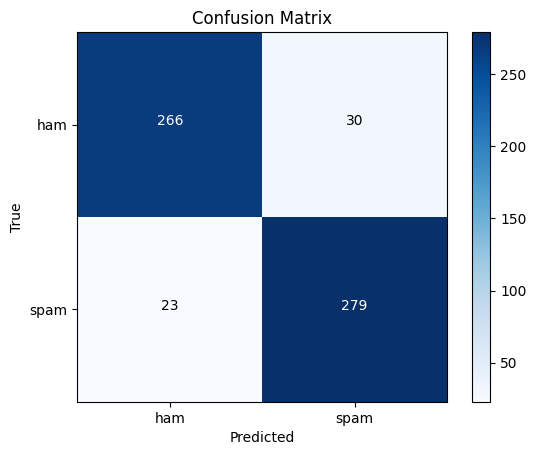

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()
tick_marks = np.arange(2)
plt.xticks(tick_marks, ['ham', 'spam'])
plt.yticks(tick_marks, ['ham', 'spam'])
plt.xlabel('Predicted')
plt.ylabel('True')

thresh = cm.max() / 2
for i, j in np.ndindex(cm.shape):
    plt.text(j, i, format(cm[i, j], 'd'), horizontalalignment="center", color="white" if cm[i, j] > thresh else "black")